In [3]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread

from gen.load_data import load_data

In [5]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../data')

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                                                image                   id  \
3271                    ../data/Train/CameraRGB/9.png                    9   
4789  ../data/Train/CameraRGB/episode_0008_000263.png  episode_0008_000263   
4432  ../data/Train/CameraRGB/episode_0004_000036.png  episode_0004_000036   
2097  ../data/Train/CameraRGB/episode_0013_000283.png  episode_0013_000283   
2763  ../data/Train/CameraRGB/episode_0007_000118.png  episode_0007_000118   

                                                label  
3271                    ../data/Train/CameraSeg/9.png  
4789  ../data/Train/CameraSeg/episode_0008_000263.png  
4432  ../data/Train/CameraSeg/episode_0004_000036.png  
2097  ../data/Train/CameraSeg/episode_0013_000283.png  
2763  ../data/Train/CameraSeg/episode_0007_000118.png  


In [6]:
from models.fcn8 import model_fcn8

model = model_fcn8(3, image_shape=(480, 480, 3), keep_prob=0.5)
model.summary()

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [7]:
model.load_weights('../saved_models/fcn8_extended_training/model.hdf5')

ValueError: You are trying to load a weight file containing 1 layers into a model with 21 layers.

In [8]:
from gen.generators import train_and_lab_gen_func, test_and_lab_gen_func

BATCH_SIZE = 32
model_dir = '../saved_models/fcn8_extended_training/'

train_gen = train_and_lab_gen_func(train_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE)
valid_gen = test_and_lab_gen_func(valid_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE)
# test_gen = train_and_lab_gen_func(test_df, image_size=(600, 800),  target_size=(480, 480),  batch_size = BATCH_SIZE)

In [9]:
from train import weighted_categorical_crossentropy
from keras.utils.training_utils import multi_gpu_model

weights = np.array([10, 5, 1])

gpus = 2

model_gpu = multi_gpu_model(model, gpus)
model_gpu.load_weights('../saved_models/fcn8_extended_training/model.hdf5')
model_gpu.compile(loss=weighted_categorical_crossentropy(weights),
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
from train import train_nn

m = train_df.shape[0]
history = train_nn(model_gpu, 
                   train_gen, 
                   valid_gen, 
                   training_size=m, 
                   batch_size=BATCH_SIZE,
                   validation_size=valid_df.shape[0],
                   output_path=model_dir, 
                   epochs=50,
                  gpus = 2)

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Reinserting dataframe: 500 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Reinserting dataframe: 500 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Reinserting dataframe: 500 images
## Ignore next message from keras,

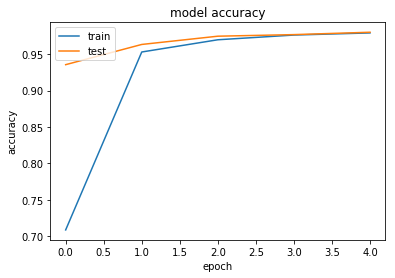

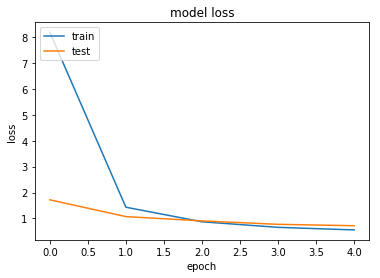

In [9]:
# # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
model.save('../saved_models/fcn8_extended_training/model_saved.h5')

In [ ]:
#valid_gen = train_and_lab_gen_func(valid_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE * gpus)
#test_gen = train_and_lab_gen_func(test_df, image_size=(600, 800),  target_size=(480, 480),  batch_size = BATCH_SIZE * gpus)